# 머신 러닝 교과서 3판

# 15장 - 심층 합성곱 신경망으로 이미지 분류 (2/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- CNN을 사용해 얼굴 이미지의 성별 분류하기
    - CelebA 데이터셋 로드하기
    - 이미지 변환과 데이터 증식
    - CNN 성별 분류기 훈련
- 요약

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt

## CNN을 사용해 얼굴 이미지의 성별 분류하기

### CelebA 데이터셋 로드하기

In [2]:
# 아래 셀에서 CelebA 데이터를 다운로드할 때 에러가 발생하면 https://git.io/JL5GM 에서
# 또는 gdown 패키지를 사용해 역자의 드라이브에서 다운로드할 수 있습니다.

import gdown
gdown.download(id='1vDDFjykRuzEagaHwwIlv6hpaHDgEUcGo', output='img_align_celeba.zip')
gdown.download(id='1XDTGJ2-QNMvkIdFwlvYAO28uc9v2d9PO', output='list_attr_celeba.txt')
gdown.download(id='1V6zDszhMCokTZTh4EZ48RB9wslY_YSCl', output='list_eval_partition.txt')
gdown.download(id='1iwam-RFy3tuh0yj29kK9tgEJOqGrH4_r', output='list_landmarks_align_celeba.txt')

!mkdir -p ~/tensorflow_datasets/downloads/manual
!cp img_align_celeba.zip ~/tensorflow_datasets/downloads/manual
!cp list_attr_celeba.txt ~/tensorflow_datasets/downloads/manual
!cp list_eval_partition.txt ~/tensorflow_datasets/downloads/manual
!cp list_landmarks_align_celeba.txt ~/tensorflow_datasets/downloads/manual

Downloading...
From: https://drive.google.com/uc?id=1vDDFjykRuzEagaHwwIlv6hpaHDgEUcGo
To: /content/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:39<00:00, 36.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XDTGJ2-QNMvkIdFwlvYAO28uc9v2d9PO
To: /content/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 35.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V6zDszhMCokTZTh4EZ48RB9wslY_YSCl
To: /content/list_eval_partition.txt
100%|██████████| 2.84M/2.84M [00:00<00:00, 206MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iwam-RFy3tuh0yj29kK9tgEJOqGrH4_r
To: /content/list_landmarks_align_celeba.txt
100%|██████████| 12.2M/12.2M [00:00<00:00, 29.9MB/s]


In [3]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('훈련 데이터셋:  {}'.format(count_items(celeba_train)))
print('검증 데이터셋:  {}'.format(count_items(celeba_valid)))
print('테스트 데이터셋: {}'.format(count_items(celeba_test)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.1.0.incompleteQ1TDLT/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.1.0.incompleteQ1TDLT/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.1.0.incompleteQ1TDLT/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.1.0. Subsequent calls will reuse this data.
dict_keys([Split('train'), Split('validation'), Split('test')])
훈련 데이터셋:  162770
검증 데이터셋:  19867
테스트 데이터셋: 19962


In [4]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('훈련 데이터셋: {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))

훈련 데이터셋: 16000
검증 데이터셋: 1000


### 이미지 변환과 데이터 증식

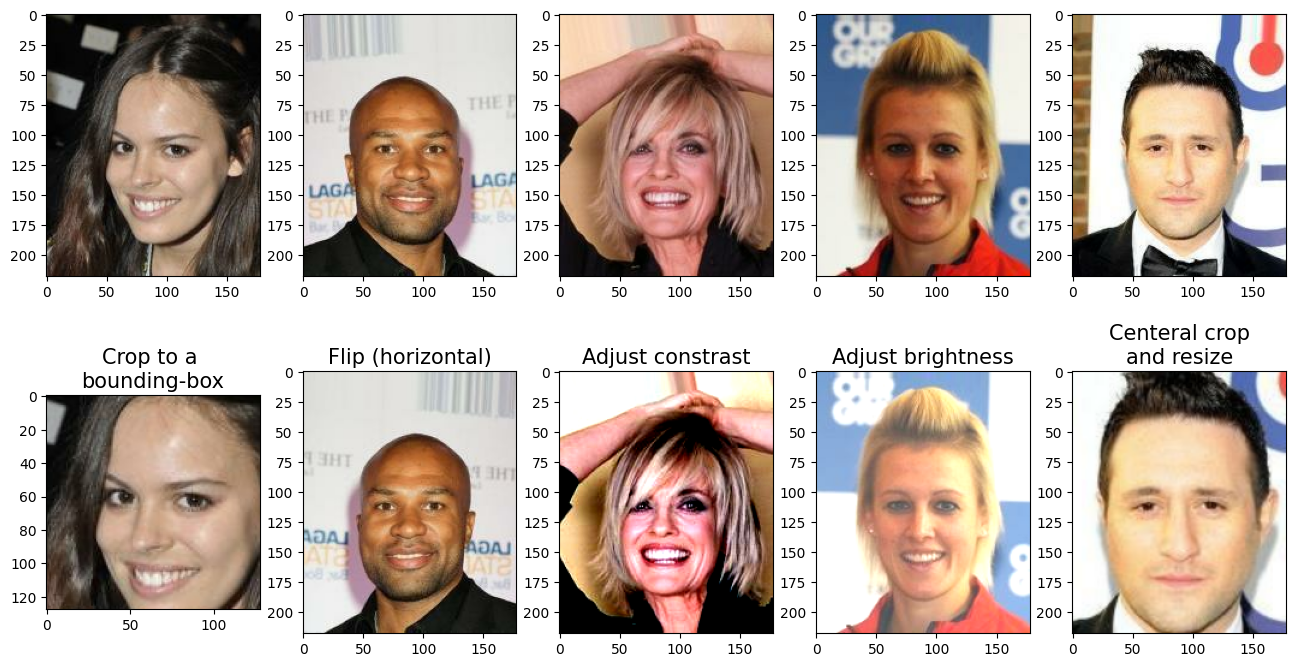

In [5]:
## 5개 샘플을 가져옵니다
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## 1열: 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## 2열: (수평으로) 뒤집기
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## 3열: 대비 조정
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열: 명도 조정
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## 5열: 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

# plt.savefig('images/15_14.png', dpi=300)
plt.show()

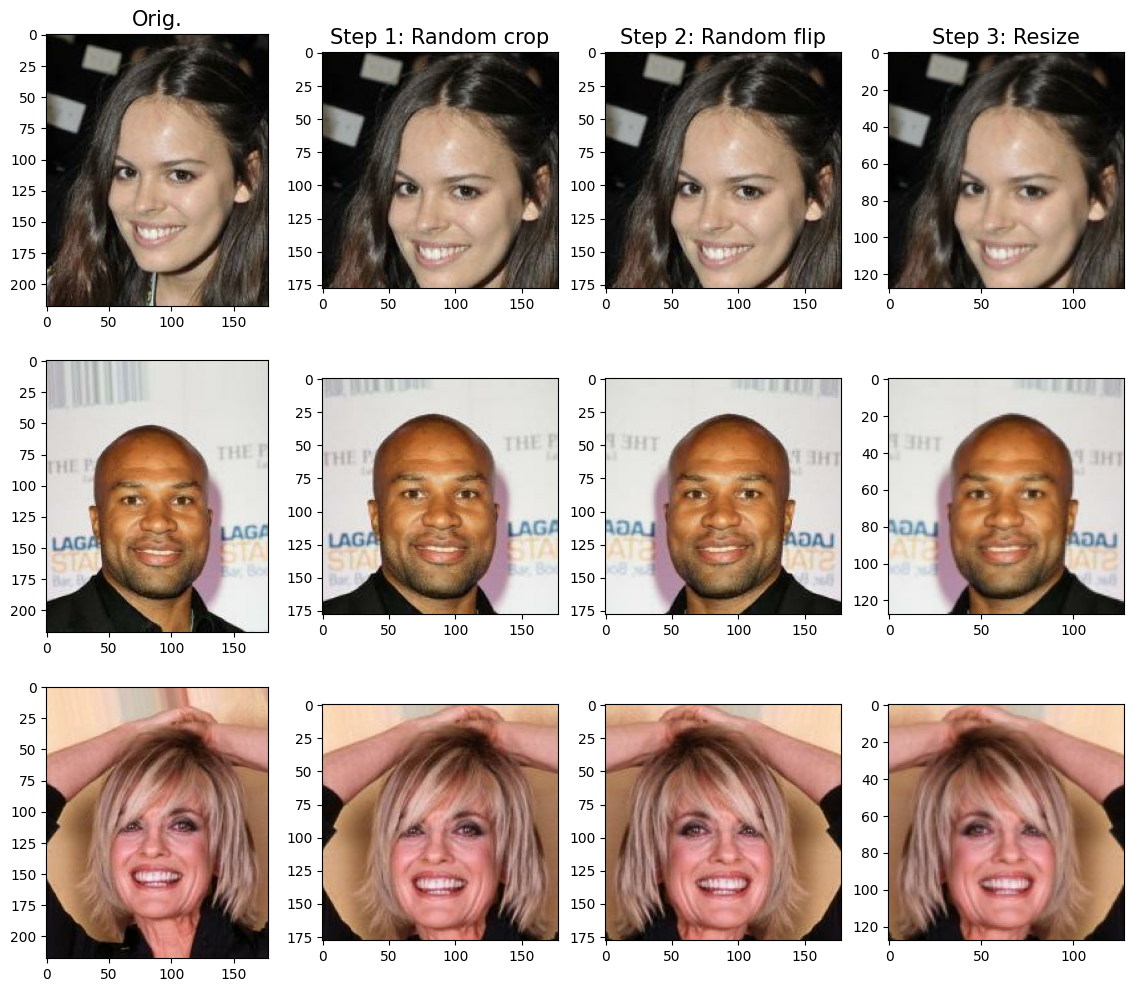

In [6]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

# plt.savefig('images/15_15.png', dpi=300)
plt.show()

In [7]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))

    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

## testing:
#item = next(iter(celeba_train))
#preprocess(item, mode='train')

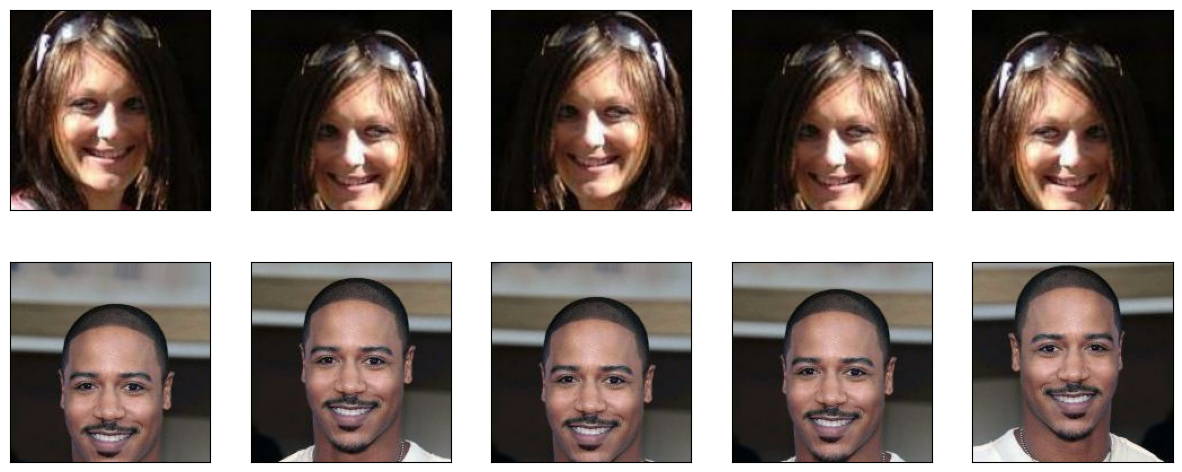

In [8]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)

ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])

# plt.savefig('images/15_16.png', dpi=300)
plt.show()

In [9]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

500.0


### CNN 성별 분류기 훈련

* **전역 평균 풀링**

In [10]:
Image(url='https://git.io/JL53N', width=800)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
])

In [12]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [13]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [14]:
model.add(tf.keras.layers.Dense(1, activation=None))

In [15]:
tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
500/500 [==============================] - 24s 25ms/step - loss: 0.6319 - accuracy: 0.6168 - val_loss: 0.5546 - val_accuracy: 0.6600
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.5307 - accuracy: 0.7183 - val_loss: 0.5074 - val_accuracy: 0.6670
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4855 - accuracy: 0.7508 - val_loss: 0.4558 - val_accuracy: 0.8330
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4393 - accuracy: 0.7811 - val_loss: 0.3497 - val_accuracy: 0.8040
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3753 - accuracy: 0.8122 - val_loss: 0.2533 - val_accuracy: 0.8730
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3198 - accuracy: 0.8484 - val_loss: 0.2093 - val_accuracy: 0.9250
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2806 - accuracy: 0.8693 - val_loss: 0.1778 - val_accuracy:

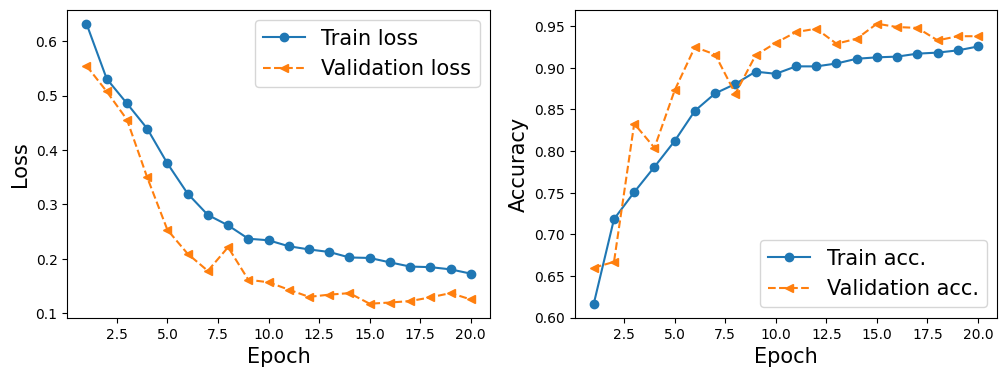

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

# plt.savefig('images/15_18.png', dpi=300)
plt.show()

In [18]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 93.33%


In [19]:
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 12s 23ms/step - loss: 0.1710 - accuracy: 0.9279 - val_loss: 0.1123 - val_accuracy: 0.9550
Epoch 22/30
500/500 [==============================] - 11s 23ms/step - loss: 0.1672 - accuracy: 0.9261 - val_loss: 0.1041 - val_accuracy: 0.9630
Epoch 23/30
500/500 [==============================] - 11s 22ms/step - loss: 0.1681 - accuracy: 0.9273 - val_loss: 0.1391 - val_accuracy: 0.9330
Epoch 24/30
500/500 [==============================] - 11s 23ms/step - loss: 0.1592 - accuracy: 0.9329 - val_loss: 0.1135 - val_accuracy: 0.9520
Epoch 25/30
500/500 [==============================] - 11s 23ms/step - loss: 0.1632 - accuracy: 0.9304 - val_loss: 0.1077 - val_accuracy: 0.9560
Epoch 26/30
500/500 [==============================] - 12s 23ms/step - loss: 0.1542 - accuracy: 0.9346 - val_loss: 0.1121 - val_accuracy: 0.9480
Epoch 27/30
500/500 [==============================] - 11s 23ms/step - loss: 0.1538 - accuracy: 0.9334 - val_loss: 0.1012 - val_ac

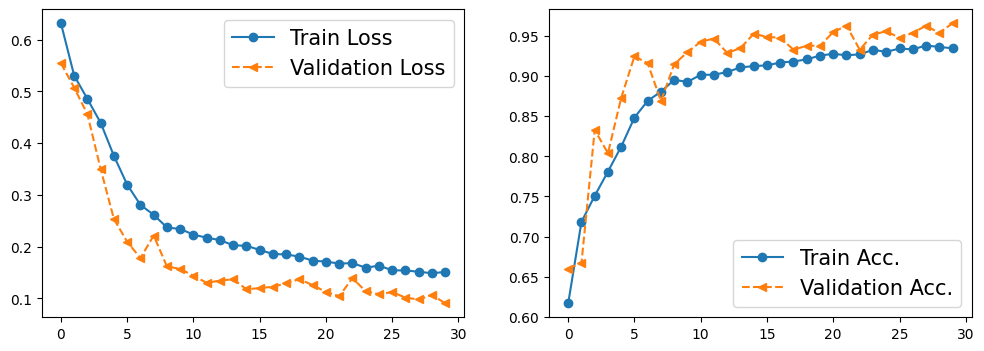

In [20]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'],
        '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'],
        '--<', label='Validation Loss')
ax.legend(fontsize=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'],
        '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'],
        '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [21]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 95.39%


1/1 [==============================] - 0s 437ms/step


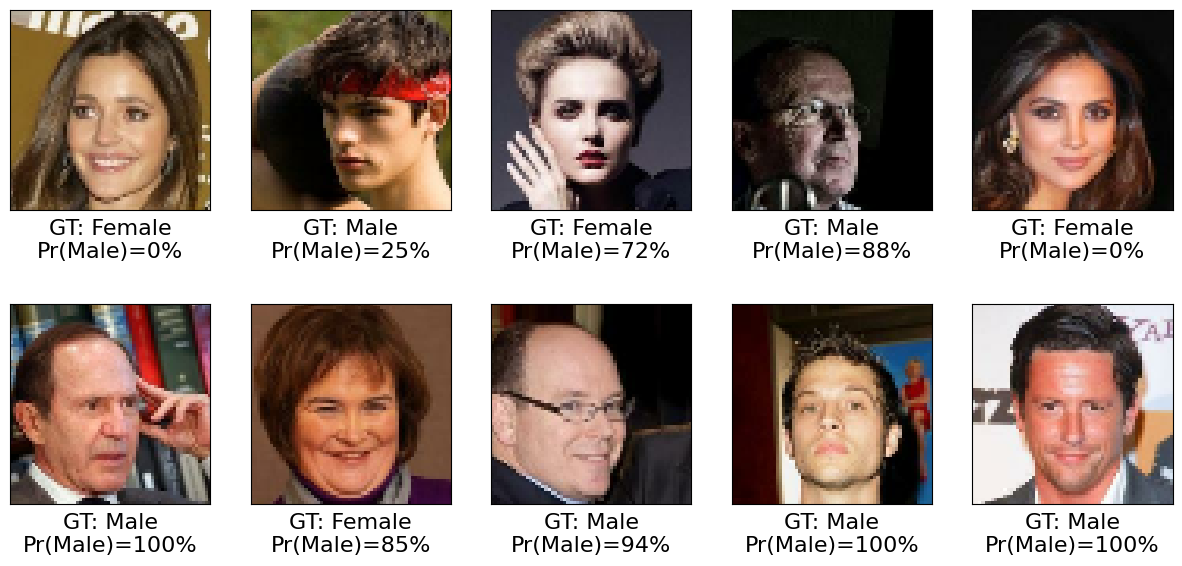

In [22]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15,
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]),
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

# plt.savefig('images/15_19.png', dpi=300)
plt.show()

In [23]:
model.save('models/celeba-cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


...


## 요약

...

## 부록:

### 초기 셔플링의 영향

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


`mnist_bldr.as_dataset(shuffle_files=False)`로 지정하면 데이터셋이 로드될 때 `mnist_valid`에 있느 레이블의 개수가 일정하게 유지됩니다. `shuffle_files` 매개변수 기본값이 `False`입니다.

In [25]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter

print('레이블 개수:', count_labels(mnist_valid))
print('레이블 개수:', count_labels(mnist_valid))

레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})


In [26]:
## MNIST dataset
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=True)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

`mnist_bldr.as_dataset(shuffle_files=True)`로 지정하면 데이터셋이 로드될 때 `mnist_valid`에 있느 레이블의 개수가 일정하게 유지되지 않습니다.

In [27]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter

print('레이블 개수:', count_labels(mnist_valid))
print('레이블 개수:', count_labels(mnist_valid))

레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
